In [53]:
# Download data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md
dev.txt  test.txt  train.txt


In [54]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [55]:
def get_lines(filename):
  with open(filename,'r') as f:
    return f.readlines()


In [56]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [57]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [58]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 706 ms, sys: 312 ms, total: 1.02 s
Wall time: 1.02 s


In [59]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [60]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [61]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [62]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [63]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

#Preparing data for deep sequence model
We have downloaded data, created a pandas df for them and hot-encoded and enncoded for labels, now we vectorize and embended them 

In [64]:
max_tokens = 68000
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)

In [65]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [66]:
text_vectorizer.adapt(train_sentences)

In [67]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
thirty-six patients were allocated to the intervention group and @ to the control group .

Length of text: 15

Vectorized text:
[[6587   12    9  379    6    2   38   13    3    6    2   35   13    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [68]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [69]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization_1',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

In [70]:
#Create an embedding
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Vectorized sentence shape: {vectorized_sentence.shape}")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
thirty-six patients were allocated to the intervention group and @ to the control group .

Sentence after vectorization (before embedding):
[[6587   12    9  379    6    2   38   13    3    6    2   35   13    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 4.9653020e-02 -3.4484040e-02 -3.7626386e-02 ... -2.2840858e-02
    3.4444008e-02  1.1009157e-02]
  [ 4.1723419e-02  4.7131207e-02 -7.0571192e-03 ...  1.7813969e-02
    7.7415816e-03 -1.7122496e-02]
  [ 2.5448885e-02  1.0649253e-02  2.6652645e-02 ... -3.2591879e-02
    2.3194816e-02 -3.7241727e-05]
  ...
  [ 4.6765320e-03 -1.7896034e-02  3.3912923e-02 ...  4.0148403e-02
   -2.9915823e-02 -1.8944515e-02]
  [ 4.6765320e-03 -1.7896034e-02  3.3912923e-02 ...  4.0148403e-02
   -2.9915823e-02 -1.8944515e-02]
  [ 4.

In [71]:
#put train  and test into tf.dataset to run faster
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
print("Composition of train_data")
print(f"train_sentences type: {type(train_sentences)}")
print(f"train_labels type: {type(train_labels_one_hot)}")
print(f"train_dataset type: {type(train_dataset)}")
print("train_dataset")
print(train_dataset)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
print(f"train_dataset type: {type(train_dataset)}")
print("train_dataset")
print(train_dataset)

Composition of train_data
train_sentences type: <class 'list'>
train_labels type: <class 'numpy.ndarray'>
train_dataset type: <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
train_dataset
<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>
train_dataset type: <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
train_dataset
<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>


In [72]:
#Create Conv1D model with functional API
inputs = layers.Input(shape=(1,), dtype=tf.string)
print(inputs.shape)
text_vectors = text_vectorizer(inputs)
print(text_vectors.shape)
token_embedding = token_embed(text_vectors)
print(token_embedding.shape)
convLayer = layers.Conv1D(64,kernel_size=5, padding="same", activation="relu")(token_embedding)
print(convLayer.shape)
pooling1 = layers.GlobalAveragePooling1D()(convLayer)
print(pooling1.shape)
outputs = layers.Dense(num_classes,activation='softmax')(pooling1)
print(outputs.shape)
model_1 = tf.keras.Model(inputs,outputs)

model_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

(None, 1)
(None, 55)
(None, 55, 128)
(None, 55, 64)
(None, 64)
(None, 5)


In [73]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_6 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_3   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 325 

In [74]:
model_1_hystory = model_1.fit(train_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 61s 108ms/step - loss: 0.9203 - accuracy: 0.6356 - val_loss: 0.6878 - val_accuracy: 0.7400
Epoch 2/5
562/562 [==============================] - 66s 117ms/step - loss: 0.6589 - accuracy: 0.7562 - val_loss: 0.6380 - val_accuracy: 0.7693
Epoch 3/5
562/562 [==============================] - 72s 128ms/step - loss: 0.6175 - accuracy: 0.7739 - val_loss: 0.5966 - val_accuracy: 0.7846
Epoch 4/5
562/562 [==============================] - 82s 146ms/step - loss: 0.5881 - accuracy: 0.7873 - val_loss: 0.5788 - val_accuracy: 0.7889
Epoch 5/5
562/562 [==============================] - 75s 134ms/step - loss: 0.5902 - accuracy: 0.7936 - val_loss: 0.5618 - val_accuracy: 0.7969


In [75]:
#Evaluating model val dataset
evaluation_val = model_1.evaluate(val_dataset)
evaluation_test =model_1.evaluate(test_dataset)
print(evaluation_val)
print(evaluation_test)

942/942 [==============================] - 6s 6ms/step - loss: 0.5739 - accuracy: 0.7953
[0.5605937838554382, 0.801237940788269]
[0.5739144086837769, 0.7953210473060608]


In [76]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

array([[5.7749701e-01, 1.4775226e-01, 3.1017577e-02, 1.9950627e-01,
        4.4226956e-02],
       [4.0290636e-01, 3.7998700e-01, 2.2727247e-02, 1.3797565e-01,
        5.6403656e-02],
       [2.0133586e-01, 3.7011118e-03, 1.3329849e-03, 7.9357225e-01,
        5.7795907e-05],
       ...,
       [3.7305614e-05, 8.1888505e-04, 5.1337210e-03, 3.5799214e-05,
        9.9397427e-01],
       [9.9460319e-02, 3.1276911e-01, 1.2216258e-01, 8.1274733e-02,
        3.8433319e-01],
       [1.6229859e-01, 7.6195788e-01, 4.9964756e-02, 1.2916861e-02,
        1.2861872e-02]], dtype=float32)

In [77]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

#Char Level Tokenization

In [79]:
# Make function to split sentences into characters
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

't h e r e   w e r e   n o   s i g n i f i c a n t   b e t w e e n - g r o u p   d i f f e r e n c e s   i n   r a t e s   o f   a c u t e   p a n c r e a t i t i s   (   p   =   @   )   o r   p a n c r e a t i c   c a n c e r   (   p   =   @   )   .'

In [80]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [81]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

In [82]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [83]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [86]:
NUM_CHAR_TOKEN = len(alphabet) + 2
char_vectorizer  = TextVectorization(max_tokens=NUM_CHAR_TOKEN,
                                   output_sequence_length=output_seq_char_len,
                                   standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer"
    
)
char_vectorizer.adapt(train_chars)

In [87]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [88]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   b i l e   a c i d   d e r i v a t i v e   @ - e t h y l c h e n o d e o x y c h o l i c   a c i d   (   o b e t i c h o l i c   a c i d   )   i s   a   p o t e n t   a c t i v a t o r   o f   t h e   f a r n e s o i d   x   n u c l e a r   r e c e p t o r   t h a t   r e d u c e s   l i v e r   f a t   a n d   f i b r o s i s   i n   a n i m a l   m o d e l s   o f   f a t t y   l i v e r   d i s e a s e   .

Length of chars: 177

Vectorized chars:
[[ 3 13  2 22  4 12  2  5 11  4 10 10  2  8  4 21  5  3  4 21  2  2  3 13
  19 12 11 13  2  6  7 10  2  7 24 19 11 13  7 12  4 11  5 11  4 10  7 22
   2  3  4 11 13  7 12  4 11  5 11  4 10  4  9  5 14  7  3  2  6  3  5 11
   3  4 21  5  3  7  8  7 17  3 13  2 17  5  8  6  2  9  7  4 10 24  6 16
  11 12  2  5  8  8  2 11  2 14  3  7  8  3 13  5  3  8  2 10 16 11  2  9
  12  4 21  2  8 17  5  3  5  6 10 17  4 22  8  7  9  4  9  4  6  5  6  4
  15  5 12 15  7 10  2 12  9  7 17 17  5  3  3 19 12  4 21  2  8 10  4  9
   2 

In [90]:
#char level embedding
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKEN, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

In [91]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [105]:
#combine chars and pretrained token embedding into a model
#1 token model
token_inputs = layers.Input(shape=[],dtype=tf.string, name='token_inputs')
print(f"token_inputs shape: {token_inputs.shape}")
token_embeddings = tf_hub_embedding_layer(token_inputs)
print(f"token_embeddings shape: {token_embeddings.shape}")
token_output = layers.Dense(128, activation="relu")(token_embeddings)
print(f"token_output shape: {token_output.shape}")
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

#2 chal model
char_input = layers.Input(shape=(1,),dtype=tf.string, name='char_inputs')
print(f"char_input shape: {char_input.shape}")
char_vectors = char_vectorizer(char_input)
print(f"char_vectors shape: {char_vectors.shape}")
char_embeddings = char_embed(char_vectors)
print(f"char_embeddings shape: {char_embeddings.shape}")
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
print(f"char_bi_lstm shape: {char_bi_lstm.shape}")
char_model = tf.keras.Model(inputs=char_input,
                            outputs=char_bi_lstm)

#3 concatenation layer
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])
print(f"token_char_concat shape: {token_char_concat.shape}")

#4 final output layer
combined_dropout_1 = layers.Dropout(0.5)(token_char_concat)
print(f"combined_dropout_1 shape: {combined_dropout_1.shape}")
combined_dense = layers.Dense(200,activation='relu')(combined_dropout_1)
print(f"combined_dense shape: {combined_dense.shape}")
combined_dropout_2 = layers.Dropout(0.5)(combined_dense)
print(f"combined_dropout_2 shape: {combined_dropout_2.shape}")
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(combined_dropout_2)
print(f"output_layer shape: {output_layer.shape}")
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

token_inputs shape: (None,)
token_embeddings shape: (None, 512)
token_output shape: (None, 128)
char_input shape: (None, 1)
char_vectors shape: (None, 290)
char_embeddings shape: (None, 290, 25)
char_bi_lstm shape: (None, 50)
token_char_concat shape: (None, 178)
combined_dropout_1 shape: (None, 178)
combined_dense shape: (None, 200)
combined_dropout_2 shape: (None, 200)
output_layer shape: (None, 5)


In [106]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

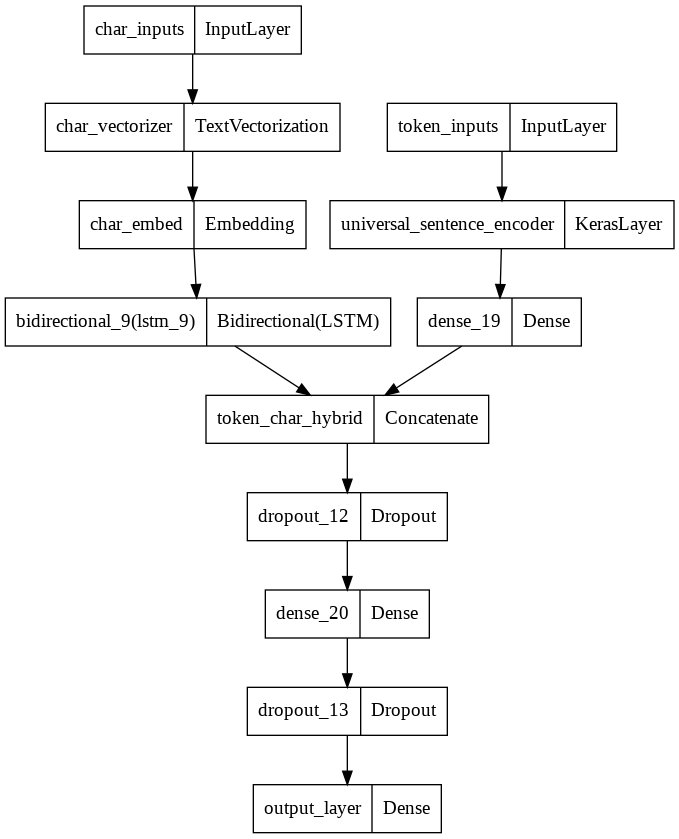

In [107]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [108]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [115]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))
print(f"train_sentences type: {type(train_sentences)}")
print(f"train_chars type: {type(train_chars)}")
print(f"train_char_token_data type: {type(train_char_token_data)}")
print(f"train_char_token_data:\n {train_char_token_data}")
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_sentences type: <class 'list'>
train_chars type: <class 'list'>
train_char_token_data type: <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
train_char_token_data:
 <TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>


In [116]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 141s 234ms/step - loss: 0.9705 - accuracy: 0.6131 - val_loss: 0.7765 - val_accuracy: 0.6995
Epoch 2/3
562/562 [==============================] - 119s 212ms/step - loss: 0.7906 - accuracy: 0.6950 - val_loss: 0.7189 - val_accuracy: 0.7267
Epoch 3/3
562/562 [==============================] - 120s 213ms/step - loss: 0.7704 - accuracy: 0.7055 - val_loss: 0.6907 - val_accuracy: 0.7370


In [117]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 45s 47ms/step - loss: 0.6922 - accuracy: 0.7366


[0.6922361850738525, 0.73656165599823]

In [118]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.2594799e-01, 3.2396257e-01, 2.9040091e-03, 2.3698677e-01,
        1.0198662e-02],
       [3.6553401e-01, 4.4529799e-01, 4.0485184e-03, 1.8174358e-01,
        3.3759314e-03],
       [3.4421861e-01, 1.3854070e-01, 4.8816513e-02, 4.2921719e-01,
        3.9206941e-02],
       ...,
       [3.5327006e-04, 8.9792842e-03, 5.1148105e-02, 2.2475737e-04,
        9.3929458e-01],
       [6.5821791e-03, 7.6822929e-02, 2.2675103e-01, 3.9241756e-03,
        6.8591970e-01],
       [3.4168252e-01, 3.4749541e-01, 2.0781024e-01, 4.5894653e-02,
        5.7117194e-02]], dtype=float32)

In [119]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>